In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/klebsiella_4species_data_processed.h5ad")


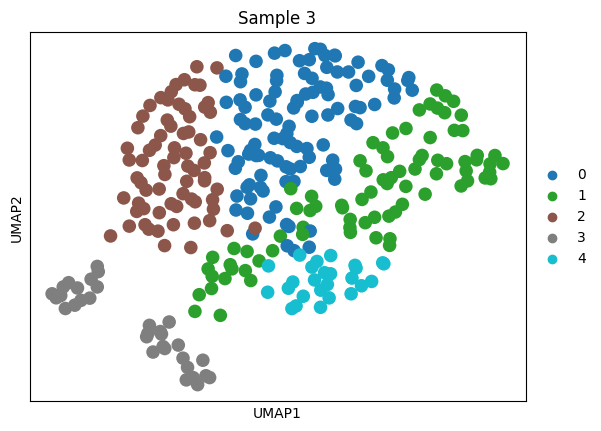

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB without starting params
gene 500
gene 600
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 800
Both NB and ZINB not converged! Using NB without starting params
gene 900
Both NB and ZINB not converged! Using NB without starting params
Bo

In [6]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
2578223750,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672013,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578223780,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360854,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223790,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578223794,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360854,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223796,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578229255,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229258,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672013,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578229259,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229260,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672013,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565


## Find optimal correlation matrix scaling and generate synthetic null data

In [8]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 1.576067526775102
Factor: 2 - Error: 1.576067526775102
Factor: 3.6180339999999998 - Error: 1.576067526775102
1


In [9]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [10]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [11]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [12]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

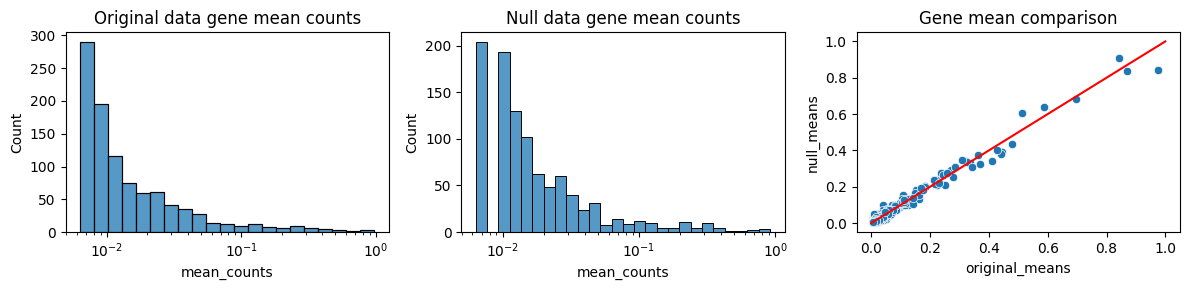

SignificanceResult(statistic=0.7609522809784698, pvalue=5.074291227060802e-188)


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

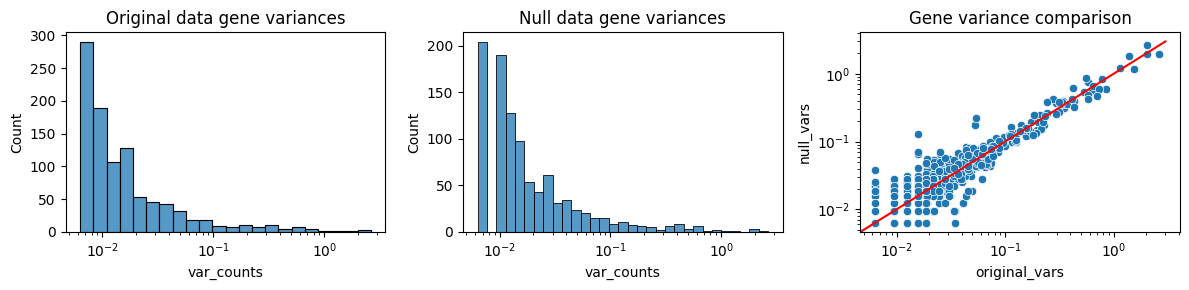

SignificanceResult(statistic=0.747727392172537, pvalue=4.551430574175515e-178)
[[1.         0.96727635]
 [0.96727635 1.        ]]


In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

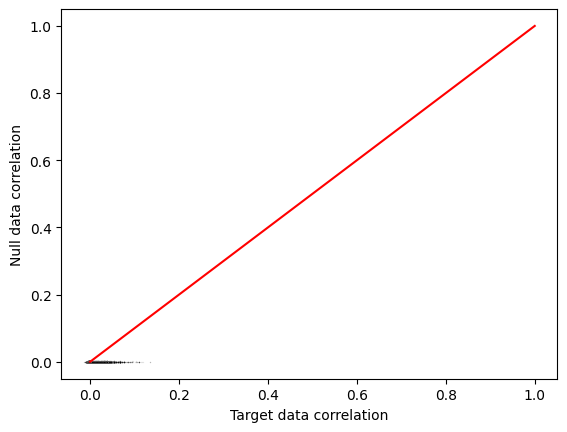

In [15]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [16]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [17]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


15


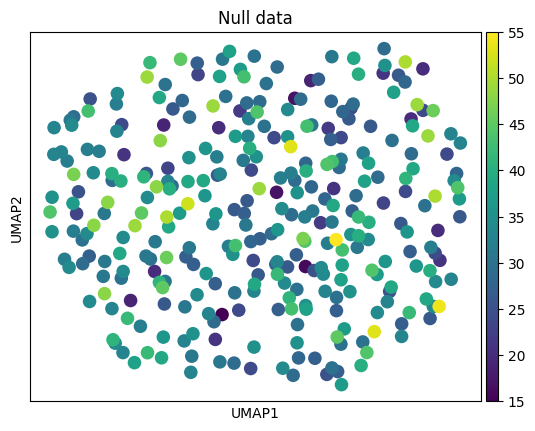

In [18]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [19]:
data_null_gen.write(data_path + "/null_data_klebsiella_4species.h5ad")

In [20]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_klebsiella_4species.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [21]:
n_splits = 20
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    max_res_1_cluster = 0
    
    while twoclust is False:
        if nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            elif max_res_1_cluster > 0: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 0.05
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 5)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}, step: {res_step}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(best_split)
print(min_pvals_null[best_split])

resolution: 0.06, clusters: 1, step: 0.01
resolution: 0.11, clusters: 1, step: 0.01
resolution: 0.16, clusters: 1, step: 0.01
resolution: 0.21, clusters: 1, step: 0.01
resolution: 0.26, clusters: 2, step: 0.01
split 1/20 - Resolution 0.26
resolution: 0.26, clusters: 2, step: 0.01
split 2/20 - Resolution 0.26
resolution: 0.26, clusters: 2, step: 0.01
split 3/20 - Resolution 0.26
resolution: 0.26, clusters: 2, step: 0.01
split 4/20 - Resolution 0.26
resolution: 0.26, clusters: 2, step: 0.01
split 5/20 - Resolution 0.26
resolution: 0.26, clusters: 3, step: 0.01
resolution: 0.25, clusters: 2, step: 0.01
split 6/20 - Resolution 0.25
resolution: 0.25, clusters: 2, step: 0.01
split 7/20 - Resolution 0.25
resolution: 0.25, clusters: 2, step: 0.01
split 8/20 - Resolution 0.25
resolution: 0.25, clusters: 2, step: 0.01
split 9/20 - Resolution 0.25
resolution: 0.25, clusters: 2, step: 0.01
split 10/20 - Resolution 0.25
resolution: 0.25, clusters: 3, step: 0.01
resolution: 0.24, clusters: 2, step: 

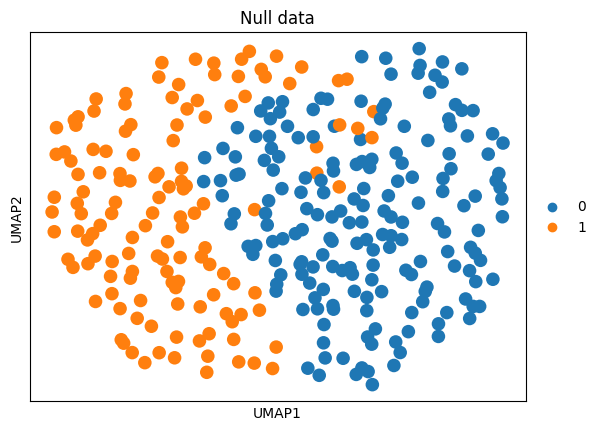

In [22]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [23]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals_dict[best_split]}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 2 - DE genes: 0; Minimum q value: 0.3333333333333333
Cluster 0 - DE genes: 0; Minimum q value: 0.16666666666666666
Cluster 1 - DE genes: 111; Minimum q value: 0.028985507246376812
Cluster 4 - DE genes: 0; Minimum q value: 0.6521739130434783
Cluster 3 - DE genes: 35; Minimum q value: 0.02857142857142857


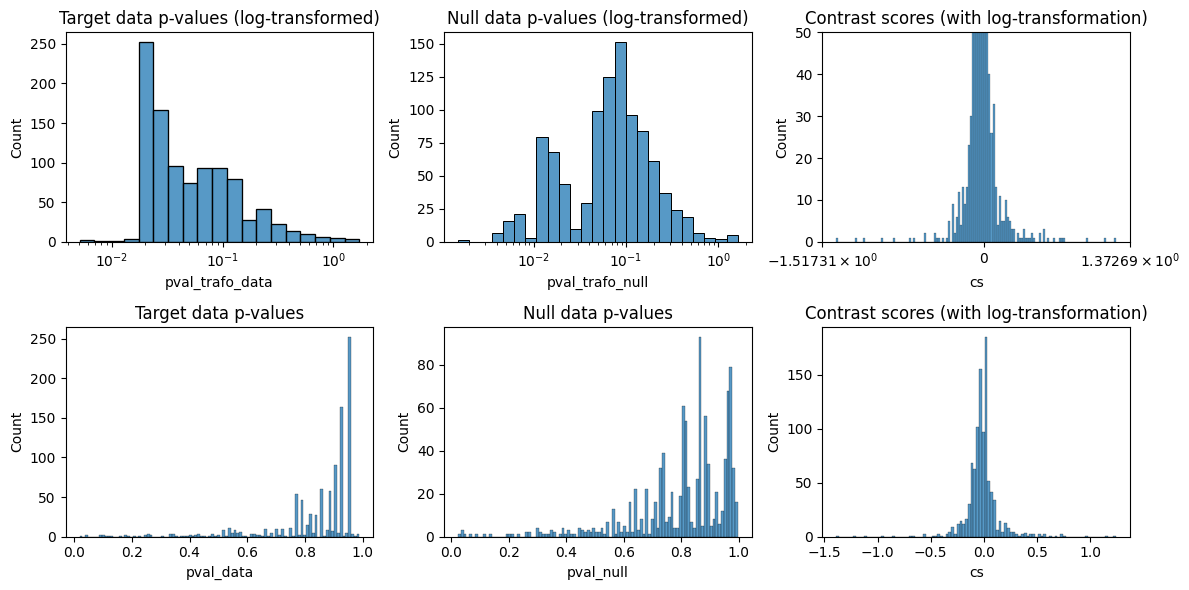

In [24]:
c = "4"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [25]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 2
0.333333     12
0.384615      1
0.411765      4
0.444444      1
0.476190      3
0.500000      1
0.521739      1
0.612903      8
0.647059      3
0.657143      1
0.684211      3
0.688889      7
0.744681      2
0.759259      7
0.781818      1
0.857143      1
0.982456      1
1.000000    934
Name: q, dtype: int64

cluster 0
0.166667      6
0.222222      3
0.250000      7
0.294118      1
0.333333      1
0.368421      1
0.380952      2
0.520000      4
0.531250      7
0.545455      1
0.611111      3
0.648649      1
0.684211      1
0.761905      4
0.767442      1
0.911111      2
0.920000      5
0.941176      1
0.980769      1
1.000000    939
Name: q, dtype: int64

cluster 1
0.028986     69
0.036145     14
0.037736     23
0.045045      5
0.053097      2
           ... 
0.649746      3
0.650338      1
0.653199      2
0.659966      3
1.000000    394
Name: q, Length: 87, dtype: int64

cluster 4
0.652174     23
0.708333      1
0.807692      2
1.000000    965
Name: q, dtype: int64

cluster 

In [26]:
pvals_log_gen["3"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
2578228320,5.844645e-08,0.269055,7.233242,0.570158,6.663083,0.028571
2578226924,1.995566e-06,0.777379,5.699934,0.109367,5.590567,0.028571
2578228004,1.540477e-05,0.755364,4.812345,0.121843,4.690501,0.028571
2578225921,1.887759e-05,0.523348,4.724053,0.281210,4.442844,0.028571
2578225894,6.381260e-05,0.607206,4.195094,0.216664,3.978430,0.028571
...,...,...,...,...,...,...
2578227413,8.698723e-01,0.301829,0.060545,0.520239,-0.459695,1.000000
2578228003,1.381867e-01,0.039576,0.859534,1.402563,-0.543029,1.000000
2578228321,5.103103e-01,0.133078,0.292166,0.875894,-0.583728,1.000000
2578227717,4.316686e-01,0.069250,0.364850,1.159578,-0.794728,1.000000


In [27]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [28]:
data_gene_nonzero.write(data_path + "/klebsiella_4species_data_processed_cluster.h5ad")

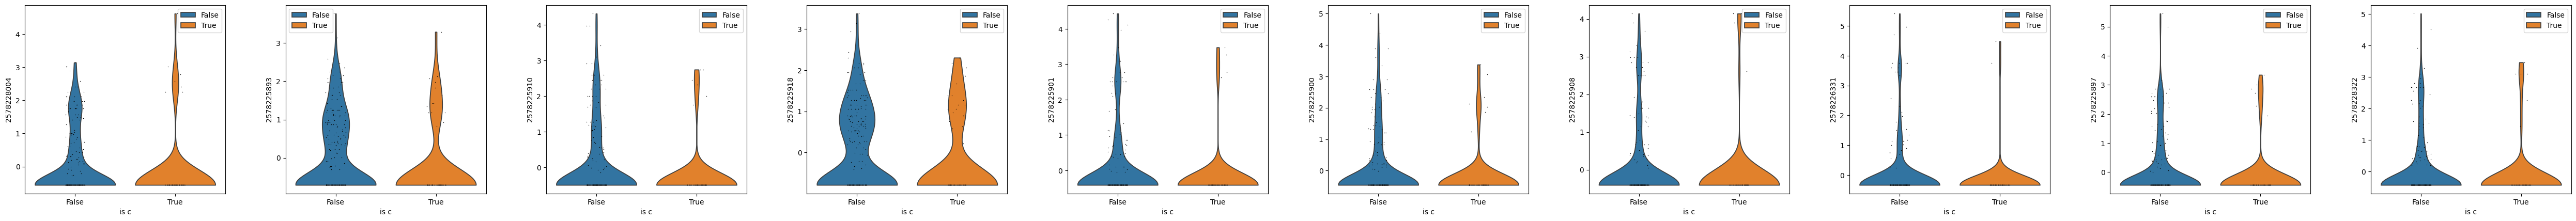

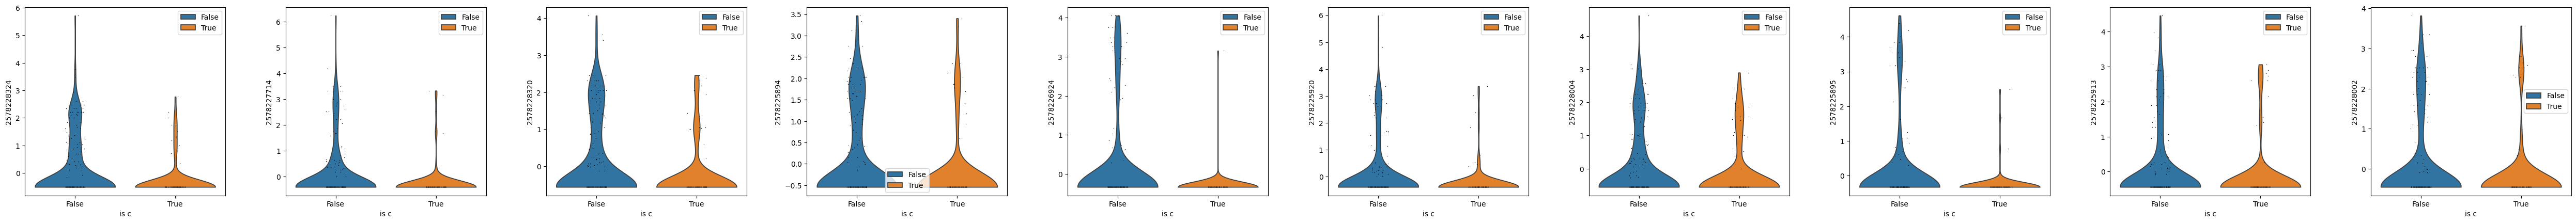

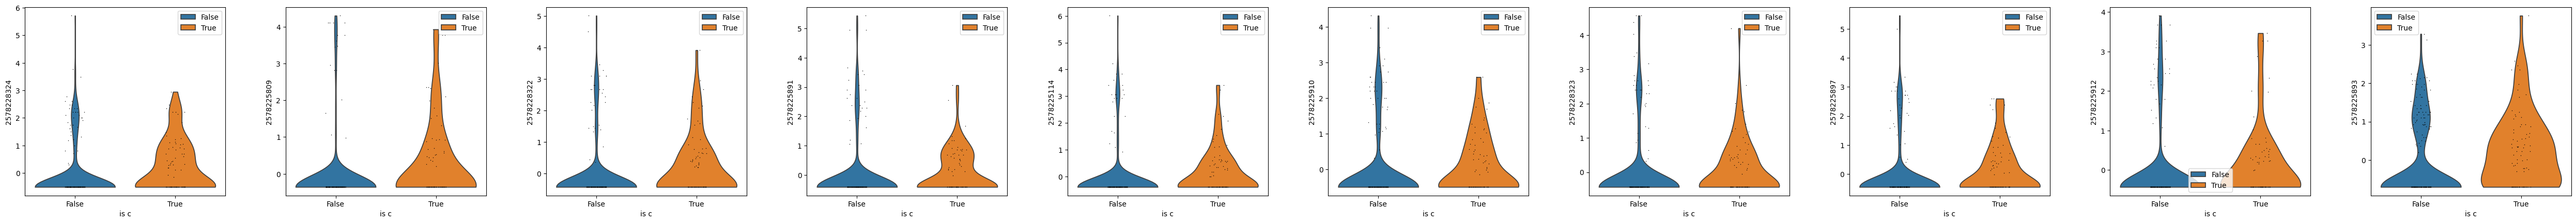

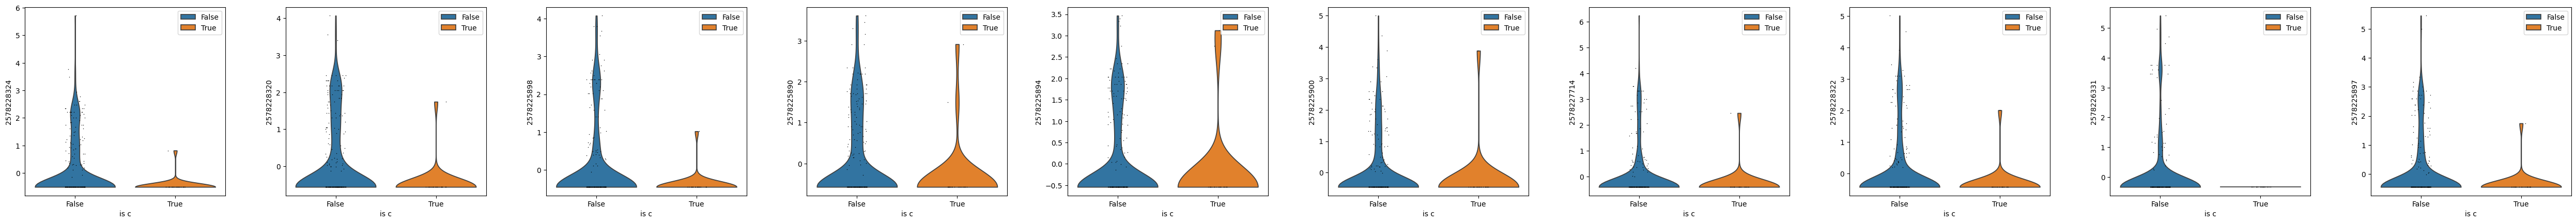

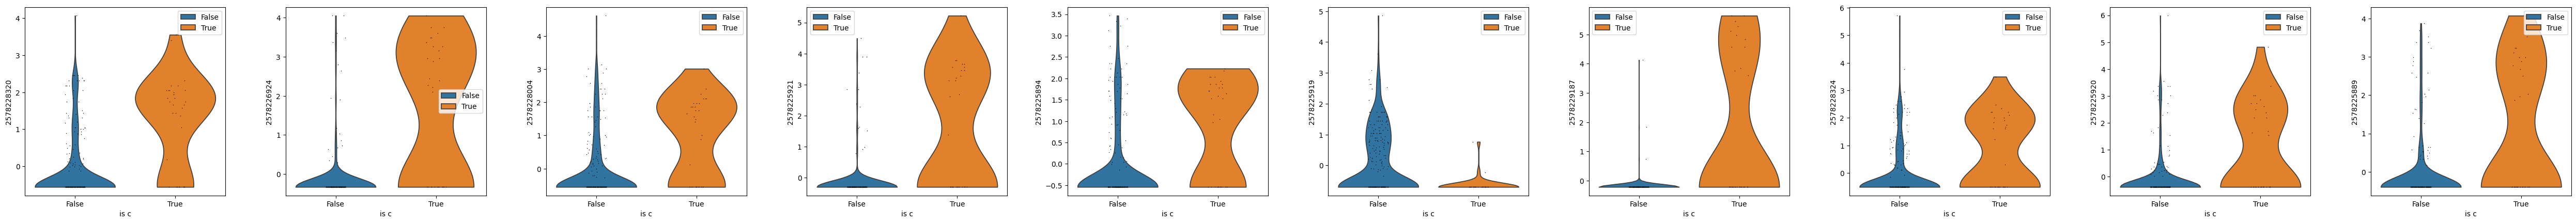

In [29]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [30]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
2578223750,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672013,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578223780,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360854,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223790,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578223794,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360854,...,NaN,NaN,NaN,0.006349,0.006309,0.000040,poi,0.006455,inf,0.017704
2578223796,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578229255,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229258,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672013,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565
2578229259,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465982,...,NaN,NaN,NaN,0.009524,0.009433,0.000091,poi,0.010585,inf,0.100562
2578229260,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672013,...,NaN,NaN,NaN,0.015873,0.015621,0.000252,poi,0.015907,inf,0.002565


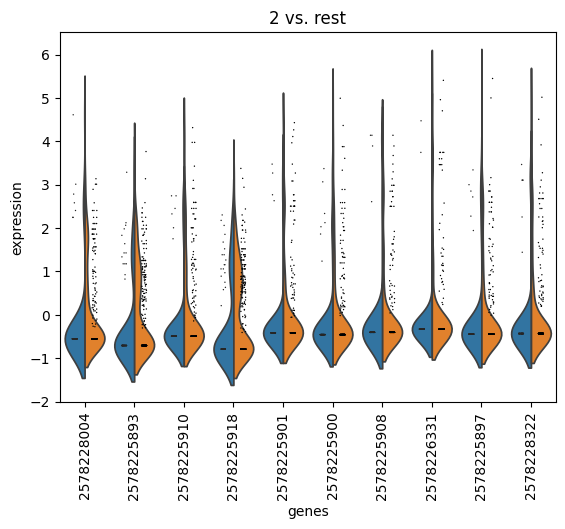

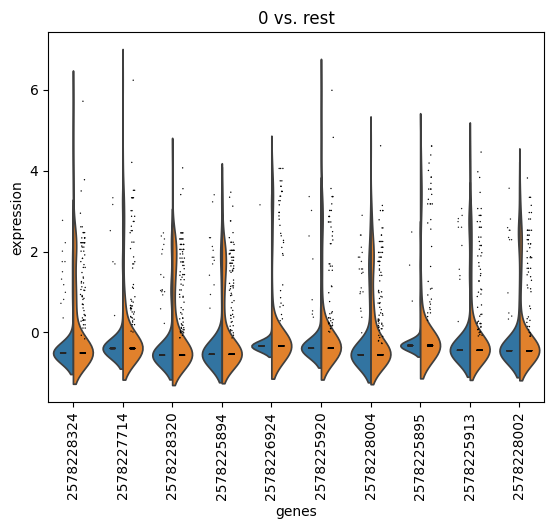

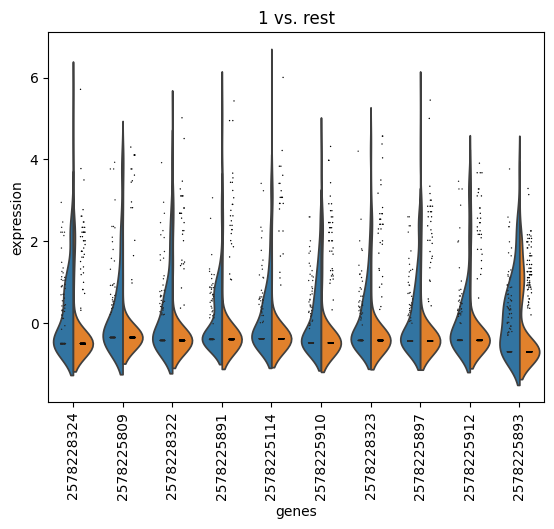

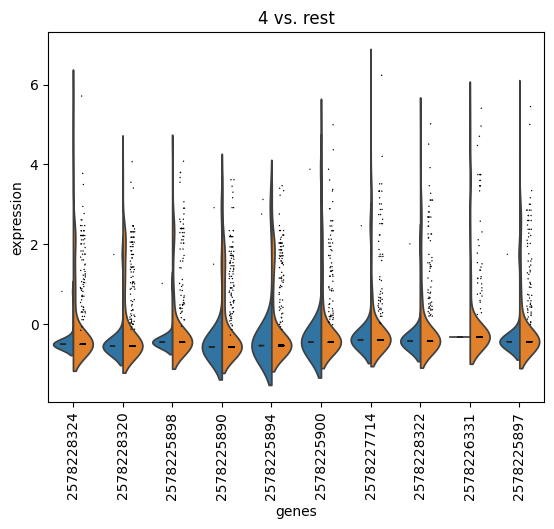

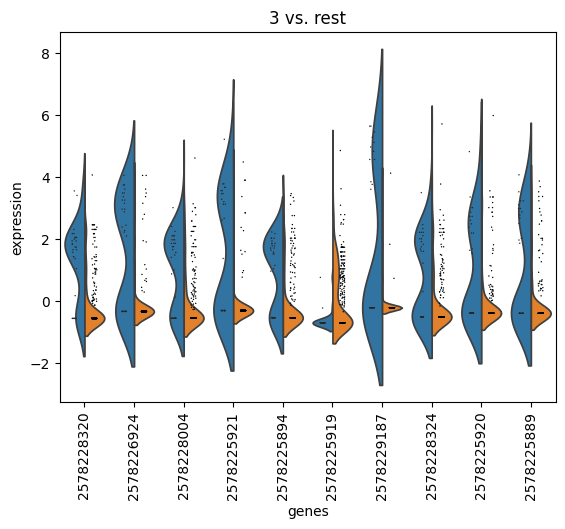

In [31]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [32]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 2
            locus_tag  name  symbol
2578228004        NaN   NaN     NaN
2578225893        NaN   NaN     NaN
2578225910        NaN   NaN     NaN
2578225918        NaN   NaN     NaN
2578225901        NaN   NaN     NaN
2578225900        NaN   NaN     NaN
2578225908        NaN   NaN     NaN
2578226331        NaN   NaN     NaN
2578225897        NaN   NaN     NaN
2578228322        NaN   NaN     NaN
Cluster 0
            locus_tag  name  symbol
2578228324        NaN   NaN     NaN
2578227714        NaN   NaN     NaN
2578228320        NaN   NaN     NaN
2578225894        NaN   NaN     NaN
2578226924        NaN   NaN     NaN
2578225920        NaN   NaN     NaN
2578228004        NaN   NaN     NaN
2578225895        NaN   NaN     NaN
2578225913        NaN   NaN     NaN
2578228002        NaN   NaN     NaN
Cluster 1
            locus_tag  name  symbol
2578228324        NaN   NaN     NaN
2578225809        NaN   NaN     NaN
2578228322        NaN   NaN     NaN
2578225891        NaN   NaN     Na

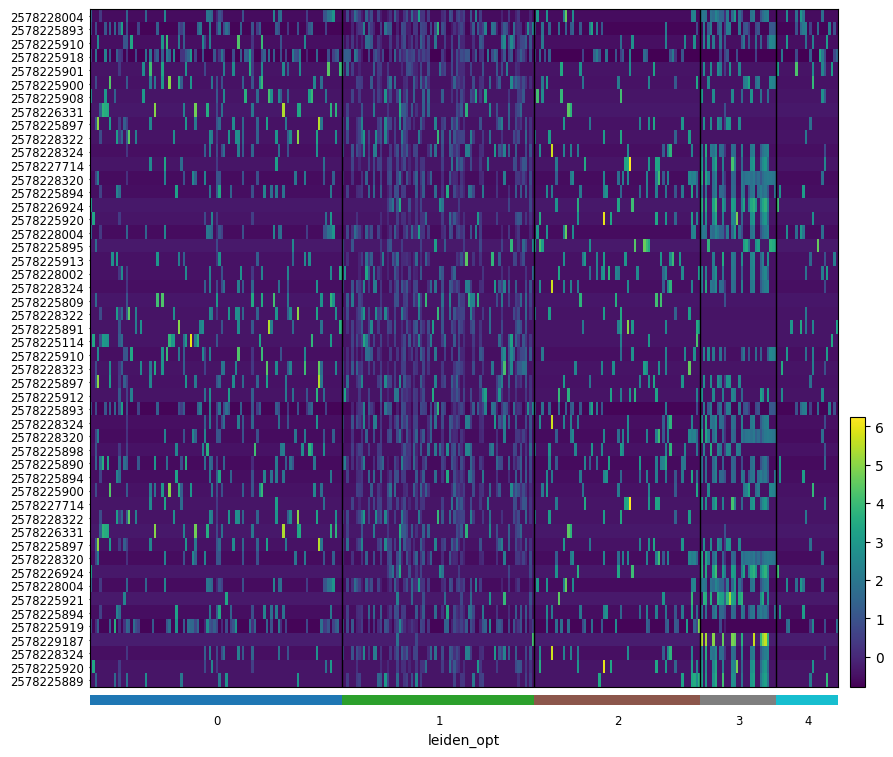

In [33]:
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)